### Evaluating Jazz album prices on Discogs.com
### Data Analysis
- program: 03_analysis.ipynb
- purpose: readin clean .csv output from 02_dataprep 
- date: jan 17, 2021
- created by: chris chan
- Methods:
    - EDA
    - OLS
    - CV for Model Selection
    - Train, Val, Test data

### 1. Pre Processing

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns 

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


Populating the interactive namespace from numpy and matplotlib


**Read-in clean dataframe**

In [ ]:
df=pd.read_csv(r'../data/clean/df_clean.csv')
df.head()

In [3]:
df.shape

(4079, 25)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4079 entries, 0 to 4078
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist_Album      4079 non-null   object 
 1   Label             4079 non-null   object 
 2   Country           4078 non-null   object 
 3   Format            4079 non-null   object 
 4   Genre             4079 non-null   object 
 5   Release_Date      4079 non-null   object 
 6   Style             4079 non-null   object 
 7   Media_Condition   4079 non-null   object 
 8   Sleeve_Condition  4072 non-null   object 
 9   Seller_Rating     4066 non-null   object 
 10  Recorded_at       2070 non-null   object 
 11  Pressed_by        1249 non-null   object 
 12  Price             4079 non-null   object 
 13  artist            4079 non-null   object 
 14  album             4079 non-null   object 
 15  reclabel          4079 non-null   object 
 16  recyear           4079 non-null   int64  


### 1. Start with numerics only

In [4]:
#simple cleaning
#df = df.replace('?', np.NaN).dropna().reset_index(drop=True)
df_recn = df.select_dtypes(exclude=['object']).copy()
df_recn.head(3)

,recyear,seller_rating,rating,votes,haves,wants,price
0,56,0.988,4.32,25.0,219,302,1100.0
1,57,1.000,4.50,16.0,68,385,2100.0
2,56,0.988,4.62,29.0,205,409,770.0


**Check for missing values**

In [14]:
df_recn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4079 entries, 0 to 4078
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recyear        4079 non-null   int64  
 1   seller_rating  4066 non-null   float64
 2   rating         3884 non-null   float64
 3   votes          3884 non-null   float64
 4   haves          4079 non-null   int64  
 5   wants          4079 non-null   int64  
 6   price          4079 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 223.2 KB


**For simplicity remove rows with missing vals (assume no ratings/votes are of lesser importance)**

In [17]:
df_recn.dropna(inplace=True)

In [18]:
df_recn.describe()

,recyear,seller_rating,rating,votes,haves,wants,price
count,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000,3872.000000
mean,62.122417,0.992272,4.440444,22.454029,198.209452,213.615961,135.972203
std,3.844362,0.026534,0.380884,29.548291,252.604120,283.146341,200.585955
min,52.000000,0.571000,1.000000,1.000000,0.000000,0.000000,40.000000
25%,59.000000,0.994000,4.260000,5.000000,48.000000,66.000000,50.000000
50%,62.000000,0.999000,4.500000,12.000000,106.000000,130.000000,76.000000
75%,65.000000,1.000000,4.670000,27.000000,251.000000,262.000000,144.282500
max,70.000000,1.000000,5.000000,209.000000,1942.000000,3679.000000,5000.000000


In [131]:
df_recn.isnull().values.any()
#df_recn.isnull().sum().sum()

False

**Cleaning Haves / Wants**
- there were very few zeros as haves and wants (<6 each)
- deciding to impute to 1 so we can perform non-zero functions

In [152]:
haveszero = np.array(df_recn['haves'].values.tolist())
df_recn['haves'] = np.where(haveszero ==0 , 1, haveszero).tolist()

wantszero = np.array(df_recn['wants'].values.tolist())
df_recn['wants'] = np.where(wantszero ==0 , 1, wantszero).tolist()

**Pair Plot**

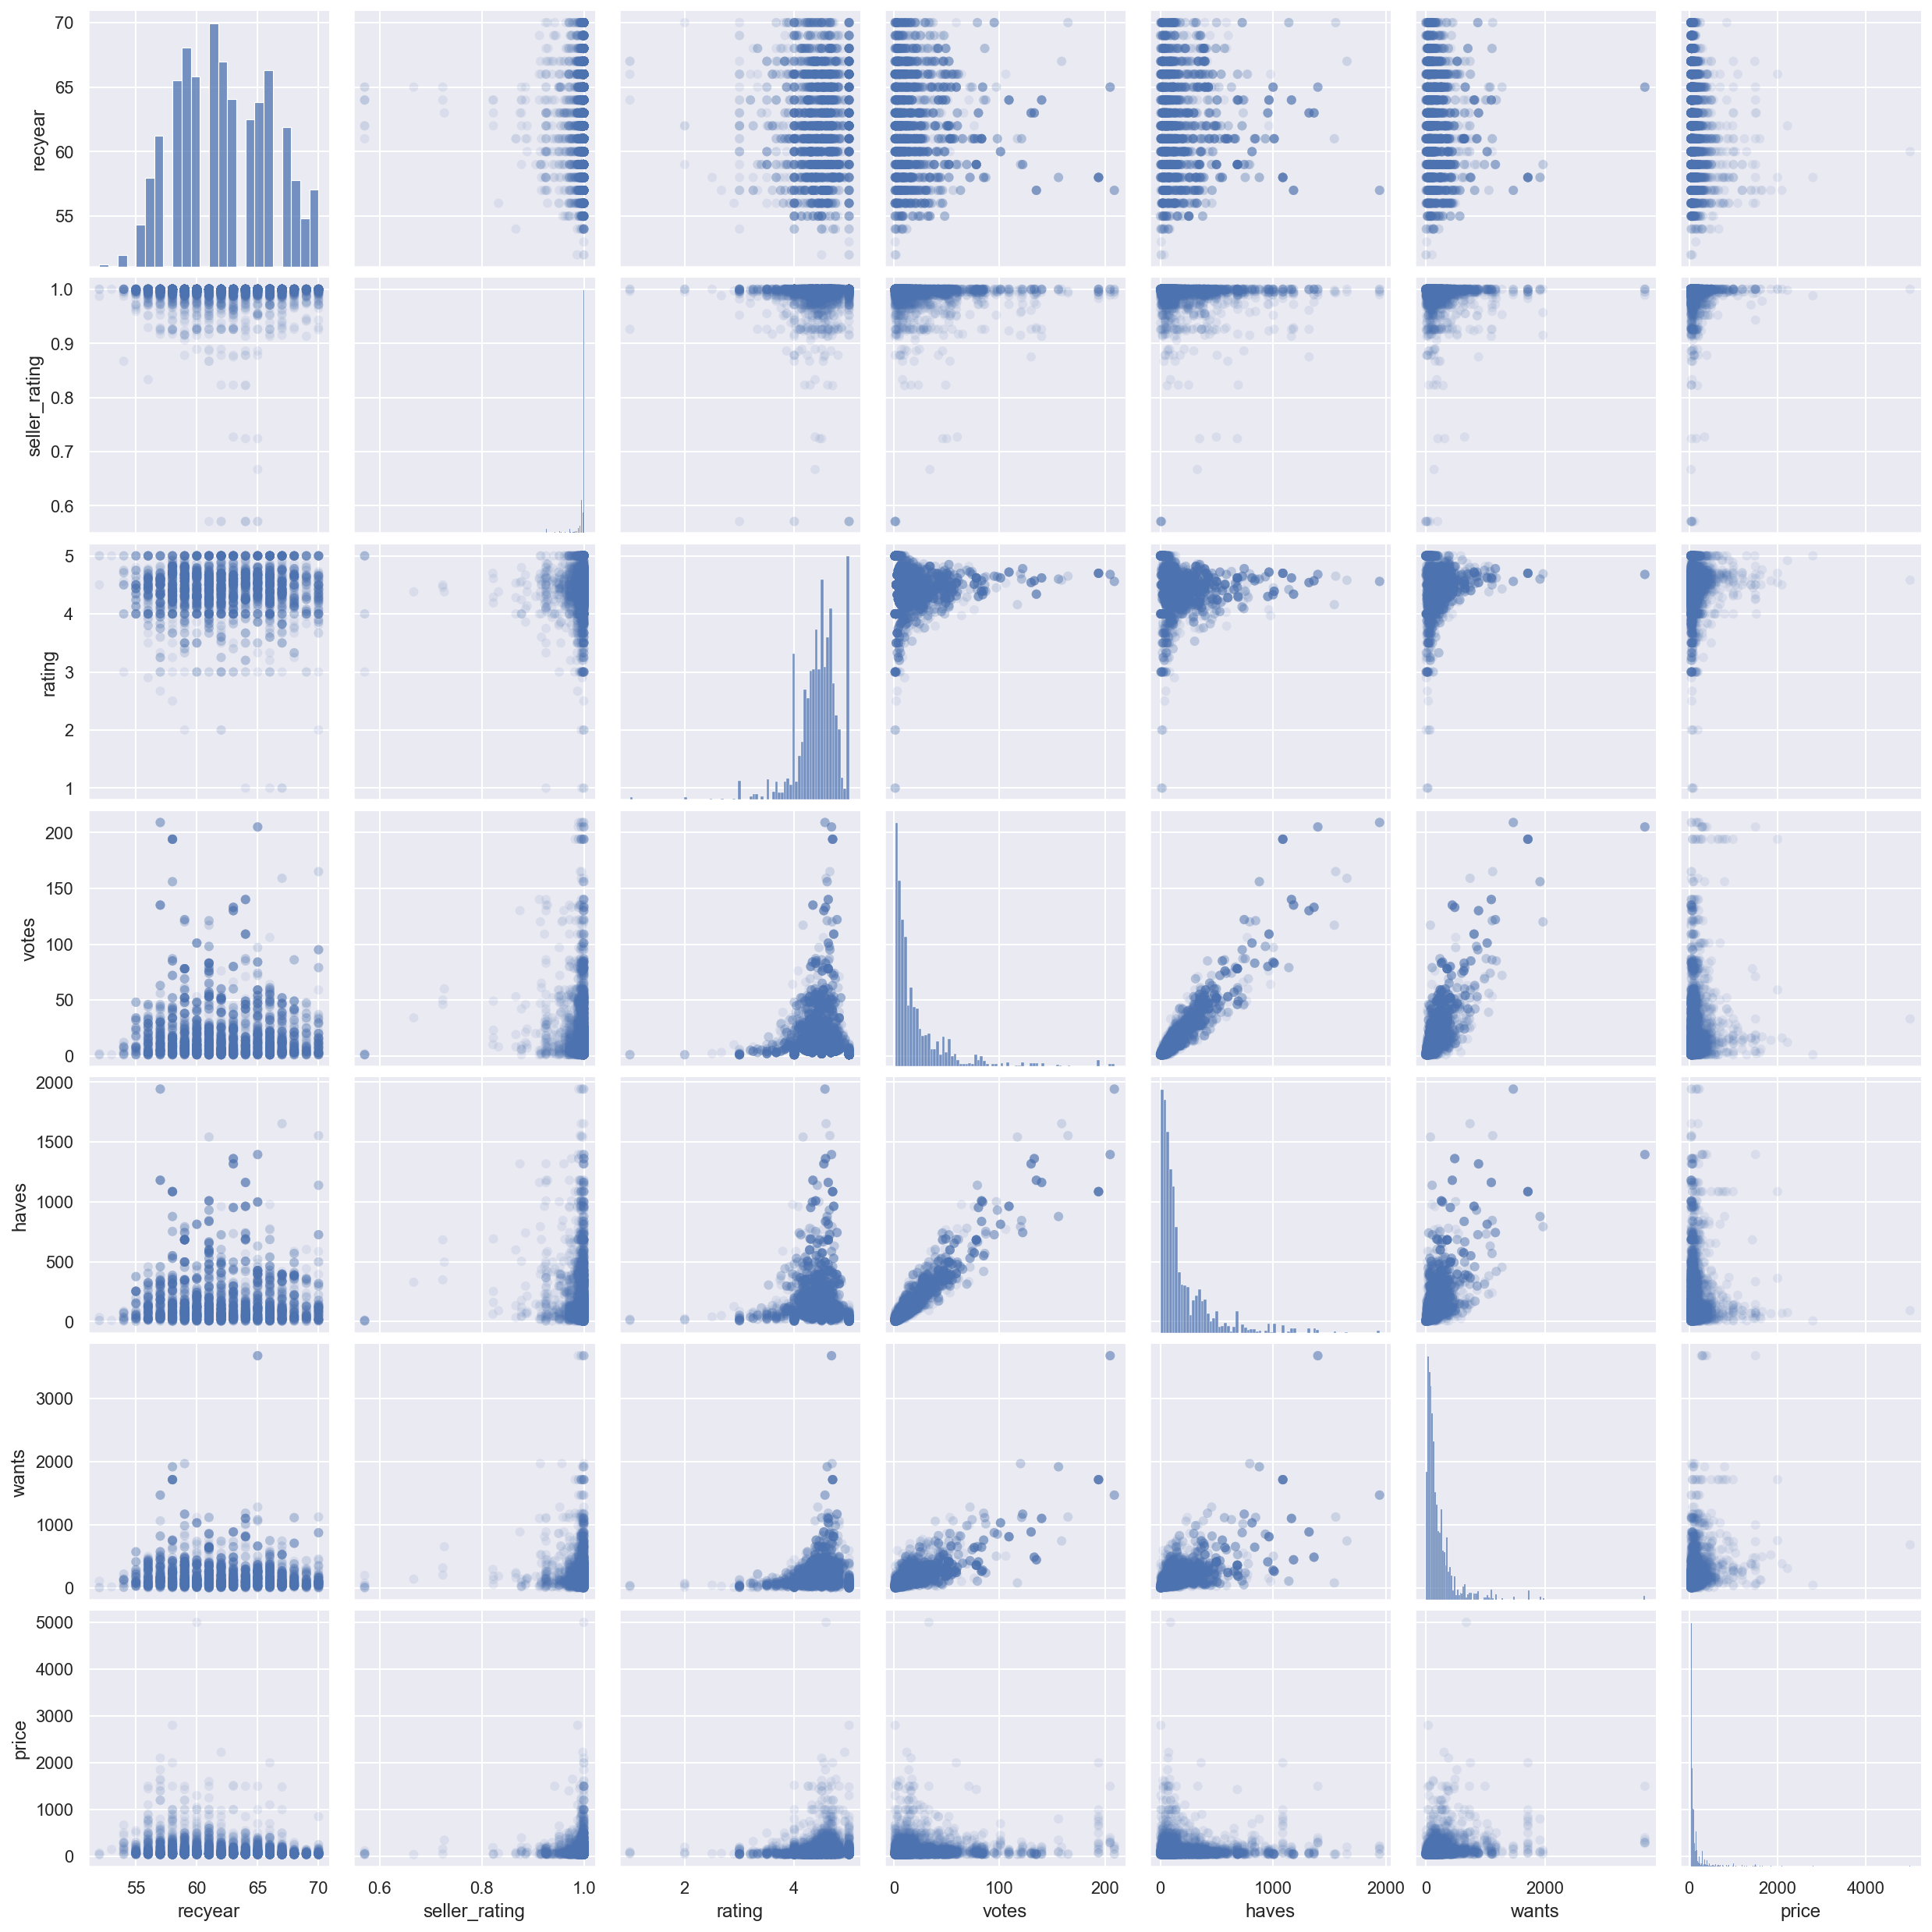

In [153]:
sns.pairplot(df_recn,plot_kws=dict(alpha=.1,edgecolor='none'))

**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

#### Setting up for modeling and building a baseline:

In [154]:
#Separate our features from our target
X = df_recn.loc[:,['recyear','seller_rating','rating','votes','haves','wants']]
y = df_recn.loc[:,['price']]

In [155]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3872 entries, 0 to 4078
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recyear        3872 non-null   int64  
 1   seller_rating  3872 non-null   float64
 2   rating         3872 non-null   float64
 3   votes          3872 non-null   float64
 4   haves          3872 non-null   int64  
 5   wants          3872 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 211.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3872 entries, 0 to 4078
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3872 non-null   float64
dtypes: float64(1)
memory usage: 60.5 KB


Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [156]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    for feature, coef in zip(X.columns, coefs):                
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

In [157]:
split_and_validate(X,y)


Validation R^2 score was: 0.11459195759613505
Feature coefficient results: 

recyear : -7.02
seller_rating : 132.44
rating : 37.94
votes : 0.66
haves : -0.25
wants : 0.24


## 2. Basic feature engineering: adding polynomial terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. **Note that you should be very careful about this in practice**, as it means that we are saving several redundant copies of the data: it's often better to continuously override the original feature set in order to save RAM.

In [158]:
X2 = X.copy()

X2['sr2'] = X2['seller_rating'] ** 2

split_and_validate(X2, y)


Validation R^2 score was: 0.11449044517269213
Feature coefficient results: 

recyear : -7.03
seller_rating : -163.64
rating : 37.88
votes : 0.66
haves : -0.25
wants : 0.24
sr2 : 173.31


As we might expect, adding appropriate square terms allows our model to do a significantly better job (+.05 R^2) capturing certain feature-target relationships that are closer to quadratic than linear. If we saw higher-order curve relationships, we could try adding higher degree polynomial terms as well.

**Note**: feature transformations are not limited to polynomial terms and can also include log and square root transforms among others. Follow your instinct based on what you see in feature-target plots, and validate!

**CC: Adding a polynomial doesn't add much**

## 3. Basic feature engineering: adding interaction terms

With our current feature set, each feature value has no influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be **interaction effects** present, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

### CC: May have to use your own JUDGEMENT, intuition and domain knowledge for interaction terms
- nothing stops you from running polynomial features, etc.
- nothing stops you from interaction terms

- however - the danger is too many features = overfitting
- therefore - regularization will help with that

- process:
    . feature engineering
    . regularization
    . repeat feedback loop

In [159]:
# Testing why infinite values- was dividing by zero

# np.isnan(X2)
# np.where(np.isnan(X2))
# np.nan_to_num(X2['wants'])

#X2.describe()
#X2.haves.value_counts(sort=False,ascending=False)
#test=round(X2['wants'] / X2['haves'] , 2).astype(float)
# test.describe()

In [160]:
X3 = X2.copy()

# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

split_and_validate(X3, y)


Validation R^2 score was: 0.13039277177640296
Feature coefficient results: 

recyear : -6.96
seller_rating : 206.63
rating : 44.97
votes : 10.97
haves : -0.30
wants : 0.24
sr2 : -25.78
rate_x_vote : -2.13
want_over_have : 5.22


## 4. Intermediate feature engineering: categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

**Categorical conversions:**

- sleeve / media conditions: Can change to ordinal ranks
- artist rankings: Can rank artists based on frequency of list
- 



0   Artist_Album      4079 non-null   object 
 1   Label             4079 non-null   object 
 2   Country           4078 non-null   object 
 3   Format            4079 non-null   object 
 4   Genre             4079 non-null   object 
 5   Release_Date      4079 non-null   object 
 6   Style             4079 non-null   object 
 7   Media_Condition   4079 non-null   object 
 8   Sleeve_Condition  4072 non-null   object 
 9   Seller_Rating     4066 non-null   object 
 10  Recorded_at       2070 non-null   object 
 11  Pressed_by        1249 non-null   object 
 12  Price             4079 non-null   object 
 13  artist            4079 non-null   object 
 14  album             4079 non-null   object 
 15  reclabel          4079 non-null   object 
 16  recyear           4079 non-null   int64  
 17  sleeve_cond_abbr  3923 non-null   object 
 18  media_cond_abbr   4079 non-null   object 
 19  seller_rating     4066 non-null   float64
 20  rating            3884 non-null   float64
 21  votes             3884 non-null   float64
 22  haves             4079 non-null   int64  
 23  wants             4079 non-null   int64  
 24  price             4079 non-null   float64

In [ ]:
df['House Style'].value_counts()